In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = torchvision.datasets.MNIST(root="./data", train = True, download=True, transform=transform)
valid_dataset = torchvision.datasets.MNIST(root="./data", train = False, download=True, transform=transform)

In [4]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=100)

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1 , hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, z_dim)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_size=28*28, hidden_size1=128, hidden_size2=16, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2 , hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [9]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [10]:
train_loss = []
num_epochs=200

In [11]:
for epoch in range(num_epochs):
  train_epoch_loss = 0
  for (imgs , _) in train_dl:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    imgs = imgs.flatten(1)
    latents = enc(imgs)
    output = dec(latents)
    loss = loss_fn(output , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()
    optimizer_enc.zero_grad()
    optimizer_dec.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
  print(f"Loss = {train_epoch_loss} for epoch number {epoch}")
  train_loss.append(train_epoch_loss)

Loss = 38.80596726760268 for epoch number 0
Loss = 32.06321459636092 for epoch number 1
Loss = 30.463723726570606 for epoch number 2
Loss = 28.431586533784866 for epoch number 3
Loss = 27.44660285115242 for epoch number 4
Loss = 26.792907118797302 for epoch number 5
Loss = 26.25948215276003 for epoch number 6
Loss = 25.80948965996504 for epoch number 7
Loss = 25.444121651351452 for epoch number 8
Loss = 25.163533497601748 for epoch number 9
Loss = 24.93766025826335 for epoch number 10
Loss = 24.711607947945595 for epoch number 11
Loss = 24.604494761675596 for epoch number 12
Loss = 24.403848201036453 for epoch number 13
Loss = 24.24248993396759 for epoch number 14
Loss = 24.126038029789925 for epoch number 15
Loss = 24.02250800281763 for epoch number 16
Loss = 23.938875790685415 for epoch number 17
Loss = 23.808924719691277 for epoch number 18
Loss = 23.726872131228447 for epoch number 19
Loss = 23.656101129949093 for epoch number 20
Loss = 23.61462497897446 for epoch number 21
Loss = 

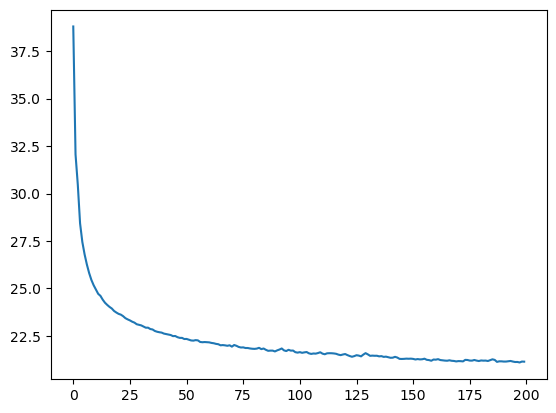

In [14]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [18]:
# values = torch.zeros(train_dataset.data.shape[0], 2)
values=None
all_labels = []
with torch.no_grad():
    for (imgs , labels) in train_dl:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if values is None:
            values = latents.cpu()
        else :
            values = torch.vstack([values, latents.cpu()])

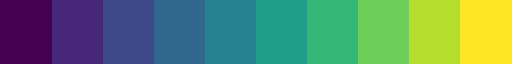

In [19]:
cmap = plt.get_cmap('viridis', 10)
cmap

In [20]:
import numpy as np
all_labels = np.array(all_labels)
values = values.numpy()

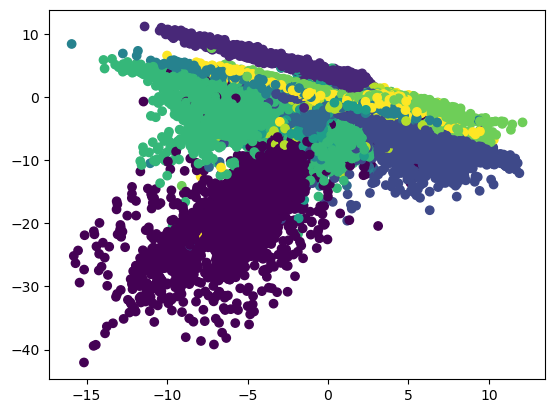

In [21]:
pc= plt.scatter(values[:, 0], values[:,1],c = all_labels, cmap=cmap)
pc

C:\Users\Shivansh\AppData\Local\Temp\ipykernel_21768\2616749951.py:1: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


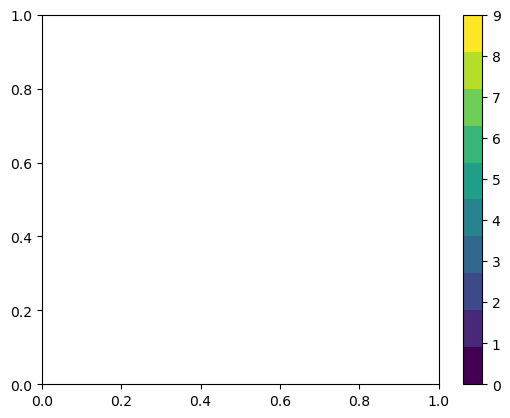

In [22]:
plt.colorbar(pc)

In [23]:
all_means ={}
for i in range(10):
    inds = np.argwhere(all_labels==i)
    num_latents = values[inds].squeeze()
    mean = num_latents.mean(axis=0)
    all_means[i] = (mean[0], mean[1])

In [24]:
all_means

{0: (-3.7891443, -12.998494),
 1: (0.61234164, 2.421893),
 2: (2.9128854, -4.514269),
 3: (-0.5950179, -3.3573751),
 4: (0.51007235, -0.20563185),
 5: (-0.021189831, -2.8593466),
 6: (-2.193537, -4.197685),
 7: (2.2313457, -0.12998874),
 8: (0.1548279, -1.8461382),
 9: (0.7465431, -0.093950935)}

In [31]:
with torch.no_grad():
    pred = dec(torch.Tensor(all_means[4])[None, ...].to(device)).cpu()

transforms.ToPILImage()(pred.reshape(1,28,28))